# MNIST klasifikacija

U ovoj svesci, naš zadatak će biti da napravimo klasfikator koji slici cifre pridružuje cifru koja se na njoj nalazi. Koristićemo poznati MNIST skup slika cifara i pristup koji je baziran na neuronskim mrežama. Koristićemo neuronsku mrežu sa propagacijom unapred, a već u sledećoj svesci, u istom zadatku klasifikacije slika, uvešćemo konvolutivne neuronske mreže koje predstavlju prirodniji izbor. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [3]:
np.random.seed(10)

## Korak 1: Učitavanje skupa podataka

MNIST je skup podataka koji sadrži slike rukom pisanih cifara. Slika ima ukupno 70000 od čega se obično 60000 slika koristi za treniranje, a preostalih 10000 za testiranje. Sve slike u skupu podataka su dimenzije 28px x 28px i u crno-belom su modu. Više o MNIST skupu podataka, kao i rezultatima dobijenim prvim algoritmima mašinskog učenja, možete pročitati [ovde](http://yann.lecun.com/exdb/mnist/).

Da bismo učitali MNIST skup podataka iskoristićemo podršku Keras biblioteke preko `mnist.load_data()` funkcije. 

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Prva instanca učitanog skupa izgleda ovako.

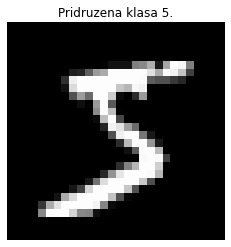

In [5]:
plt.title('Pridruzena klasa {0}.'.format(y_train[0]))
plt.axis('off')
plt.imshow(X_train[0], cmap='gray')
plt.show()

Kao što možemo videti, skup za treniranje sadrži 60000 instanci formata 28x28.

In [6]:
print(X_train.shape)

(60000, 28, 28)


Skup za testiranje sadrži 10000 instanci formata 28x28.

In [7]:
print(X_test.shape)

(10000, 28, 28)


## Korak 2: Priprema podataka

Da bismo slike prosledili kao ulaze mreže, transformisaćemo ih u vektore dužine 28x28=784.

In [8]:
image_size = X_train.shape[1]

X_train = X_train.reshape(X_train.shape[0], image_size*image_size)
X_test = X_test.reshape(X_test.shape[0], image_size*image_size)

In [9]:
print(X_train.shape)

(60000, 784)


In [10]:
print(X_test.shape)

(10000, 784)


Slike ćemo pripremiti tako što ćemo ih normalizovati, tj. svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1]. Prethodno ćemo promeniti tip elemenata matrice sa *uint8* na *float32* kako bi mogli da sačuvamo realne vrednosti.

In [11]:
X_train.dtype

dtype('uint8')

In [12]:
X_train = X_train.astype('float32')
X_train /= 255

In [13]:
X_test = X_test.astype('float32')
X_test /= 255

Kao što smo videli, vrednosti ciljne promenljive su brojevi od 0 od 9. Uvid u brojnost instanci po klasama možemo dobiti na osnovu sledećeg grafika.

In [14]:
classes = np.unique(y_train)

In [15]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

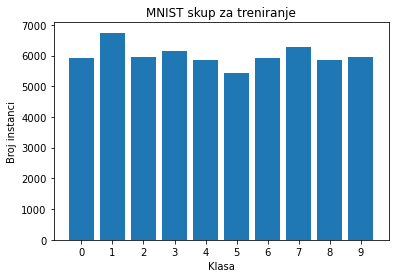

In [16]:
plt.xlabel('Klasa')
plt.ylabel('Broj instanci')
plt.title ('MNIST skup za treniranje')

plt.xticks(classes)

plt.bar(classes, np.bincount(y_train))
plt.show()

Vrednosti ciljne promenljive ćemo pripremiti tako što ćemo ih transformisati u vektore dužine 10 sa jedinicom na poziciji koja odgovara vrednosti cifre (takozvano *one-hot* kodiranje). Na primer, broj 3 će biti transformisan u vektor \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\] sa jedinicom na poziciji tri. 

Za ovu transformaciju iskoristićemo funkciju `to_categorical` paketa `keras.utils`.

In [17]:
number_of_classes = classes.shape[0]

y_train = keras.utils.to_categorical(y_train, number_of_classes)
y_test = keras.utils.to_categorical(y_test, number_of_classes)

In [18]:
print(y_train.shape)

(60000, 10)


Na primer, prvoj instanci skupa za treniranje, cifri 5, je sada pridružen vektor:

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Korak 3: Pravljenje modela

Na slici je prikazana arhitekture mreže koju ćemo kreirati. 

<img src="assets/mlp_mnist.png" />

#### Ulazni sloj

Ulaz u mrežu je "ispravljena" slika dimenzije 784 piksela.

<img src="assets/mnist-input.png" />


#### Skriveni slojevi

Mreža ima dva skrivena sloja, jedan dimenzije 128 neurona i drugi dimenzije 64 neurona. Oba sloja kao aktivaciju koriste *relu* funkciju.



#### Izlazni sloj

Izlazni sloj mreže ima 10 neurona. Svaki od njih odgovara jednoj od cifara od 0 do 9. Ideja je da vrednosti izlaza predstavljaju verovatnoće pripadanja odgovarajućoj klasi cifara. Preciznije, ako se za ulaz *img* koji predstavlja sliku dobija izlaz oblika $(v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9)$ rezultat tj. klasa pripadanja će biti ona vrednost $i$ za koju je $v_i$ maksimalno. Na primer, ako $v_4$ ima najveću vrednost, onda zaključujemo da slika *img*  predstavlja broj 4. 

Zato ćemo u poslednjem sloju mreže kao aktivacionu funkciju iskoristiti funkciju mekog maksimuma (engl. softmax) koja vrednost $v_i$ mapira u vrednost $\frac{e^{v_i}}{\sum_j{e^{v_j}}}$

In [20]:
model = Sequential([
    Input(shape=(image_size*image_size, )), 
    Dense(units=128, activation='relu'), 
    Dense(units=64, activation='relu'),
    Dense(units=number_of_classes, activation='softmax')
])

Model možemo kontrolno prikazati pozivom metode `summary`.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


U zadacima višeklasne klasifikacije, uz aktivaciju mekog maksimuma u zadanjem sloju, obično se kao funkcija gubitka koristi `kategorička unakrsna entropija` (engl. categorical crossentropy). Ona predstavlja uopštenje binarne unakrsne entropije i računa se po formuli $-\sum_i{y_i \cdot log(\hat{y_i})}$ u kojoj $\hat{y_i}$ predstavlja predikciju mreže za instacu $i$, a $y_i$ njenu stvarnu vrednost. 

Kao optimizator ćemo koristiti `Adam`.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Mrežu ćemo trenirati u 30 epoha korišćenjem paketića veličine 128 instanci.

In [23]:
batch_size = 128
epochs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

Možemo nacrtati i grafike funkcije gubitka i tačnosti u toku treniranja. 

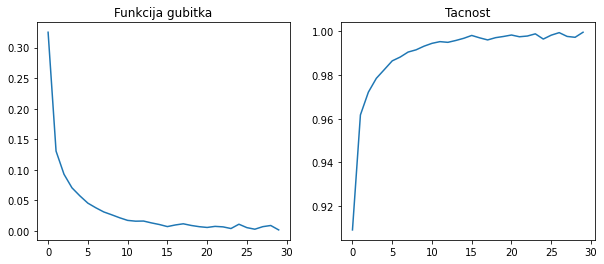

In [24]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Funkcija gubitka')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')

plt.subplot(1, 2, 2)
plt.title('Tacnost')
plt.plot(np.arange(0, epochs), history.history['accuracy'])

plt.show()

Model ćemo oceniti na skupu za testiranje.

In [25]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.1163 - accuracy: 0.9781
Test loss: 0.11633738875389099
Test accuracy: 0.9781000018119812


Vrednosti koje smo očitali iz promenljive `score` su usklađene sa imenima metrika koje su korišćene:

In [26]:
model.metrics_names

['loss', 'accuracy']

### Korak 4: Analiza prostora grešaka

Videli smo da model daje dobru ocenu tačnosti. U praksi je značajno izdvojiti i instance na kojima model ne radi dobro u cilju boljeg razumevanja njegovog rada i budućih popravki.

Kreiraćemo prvo niz sa predikcijama modela.

In [27]:
y_predictions = model.predict(X_test)

Možemo nacrtati, na primer, prvih 20 instanci test skupa i obeležja koja im pridružuje klasifikator. 

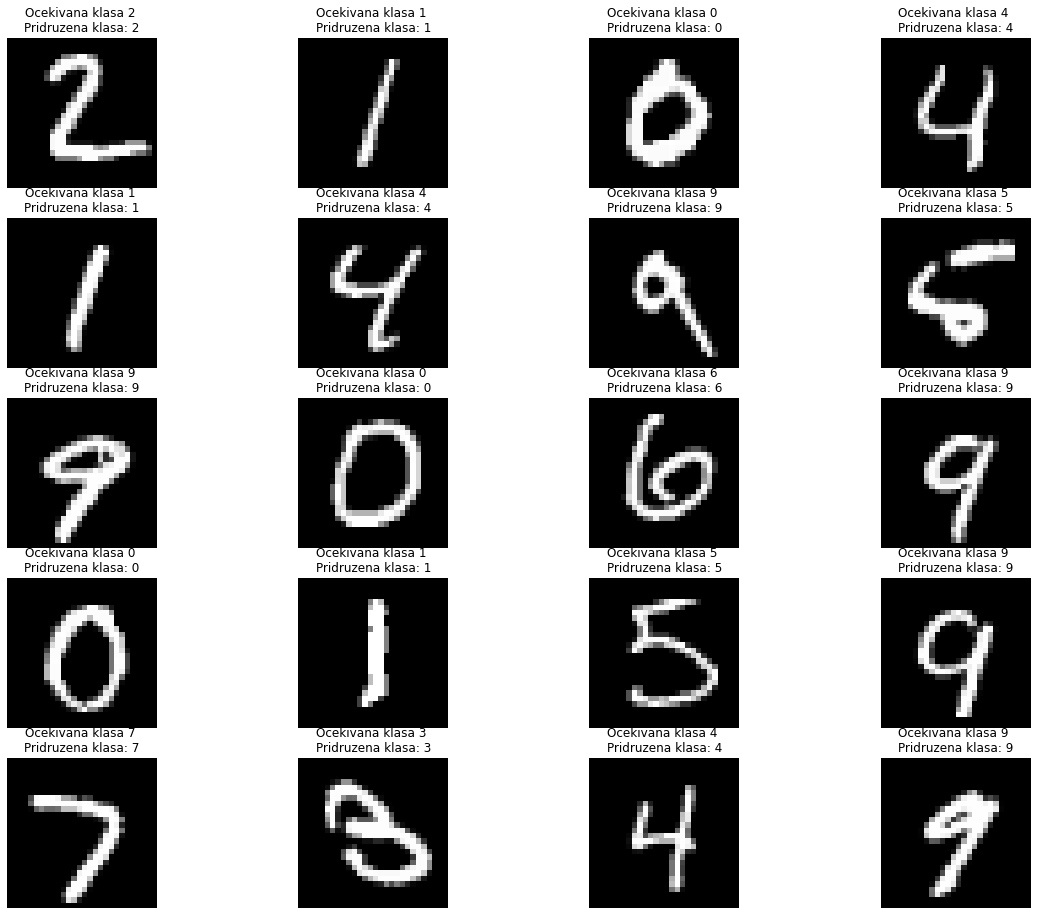

In [28]:
fig = plt.figure(figsize=(20, 16))
columns = 4
rows = 5
for i in range(1, rows*columns +1):
    # kreiramo blok u okviru kojeg ćemo prikazati sliku
    fig.add_subplot(rows, columns, i)

    # dohvatamo odgovarajući vektor slike i transformišemo ga u 2D sliku dimenzija 28x28
    img = X_test[i].reshape(image_size, image_size)
    
    # postavljamo u bloku naslov koji sadrzi tacnu vrednosti i predviđenu vrednosti
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(y_predictions[i])
    plt.title('Ocekivana klasa {0} \nPridruzena klasa: {1}'.format(true_label, predicted_label))
    plt.axis('off')
    
    # prikazujemo sliku
    plt.imshow(img, cmap='gray')
    
plt.show()

Vidimo da su sve izdvojene slike dobro klasifikovane. 

Sada ćemo pronaći one slike kod kojih se stvarna obeležja i predikcije razlikuju. Za pronalaženje obeležja iskoristićemo funkciju `np.argmax` koja pronalazi poziciju maksimalne vrednosti u nizu, a koja se uklapa u reprezentacije dobijene primenom aktivacije mekog maksimuma za predikcije.

In [29]:
y_predictions[0]

array([9.8285333e-15, 3.7123744e-16, 7.3230998e-11, 1.8126524e-08,
       7.2373045e-21, 7.7445693e-14, 2.8702310e-25, 1.0000000e+00,
       1.5750538e-13, 7.1743353e-12], dtype=float32)

In [30]:
np.argmax(y_predictions[0])

7

In [31]:
predicted_labels = np.argmax(y_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
error_indexes = np.where(predicted_labels != true_labels)[0]

U praksi se često susreće i forma `np.argmax(..., axis=-1)` korišćenja `argmax` funkcije u kojoj se sa `axis=-1` naglašava izračunavanje duž poslednje dimenzije (u našem slučaju vrste).  <img src='assets/axis.png'>

Broj instanci koje je klasifikator pogrešno klasifikovao:

In [32]:
number_of_errors = len(error_indexes)
number_of_errors

219

Prikazaćemo neku od slika sa pogrešnom labelom.

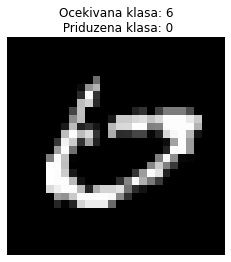

In [33]:
error_index = np.random.choice(error_indexes)
true_label = true_labels[error_index]
predicted_label = predicted_labels[error_index]

plt.title("Ocekivana klasa: {0}\n Priduzena klasa: {1}".format(true_label, predicted_label))
plt.imshow(X_test[error_index].reshape(image_size, image_size), cmap='gray')
plt.axis('off')
plt.show()